In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True)

X = X.values
X = ((X / 255.) - .5) * 2

y = y.astype(int).values

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

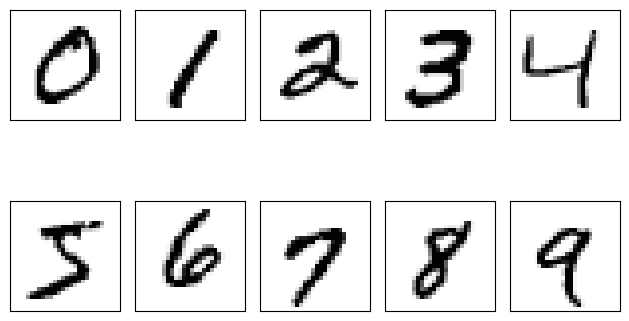

In [4]:
fig, axs = plt.subplots(2, 5, sharex = True, sharey = True)
axs = axs.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    axs[i].imshow(img, cmap = 'Greys')
    
axs[0].set_xticks([])
axs[0].set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 10000, random_state = 123, stratify = y) 

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size = 5000, random_state = 123, stratify = y_train
    )

In [6]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    
    for i, val in enumerate(y):
        ary[i, val] = 1
        
    return (ary)

In [7]:
class NeuralNetMLP:
    
    def __init__(self,
                 num_feat : int,
                 num_hidden : int,
                 num_classes : int,
                 rnd_state = 123):
        
        super().__init__()
        rng =np.random.RandomState(rnd_state)
        
        self.num_classes = num_classes
        
        # Hidden layer
        self.weight_h = rng.normal(loc = 0, scale = 0.1, size = (num_hidden, num_feat)) ## Matrix (m x d)
        self.bias_h = np.zeros(num_hidden) ## Matrix (1 x d)
        
        # Output layer
        self.weight_out = rng.normal(loc = 0, scale = 0.1, size = (num_classes, num_hidden)) ## Matrix (d x t)
        self.bias_out = np.zeros(num_classes) ## Matrix (1 x t)
        
    def forward(self, x):
        # Hidden layer
        ## input_dim = [n_examples, n_features]
        ##       dot = [n_classes, n_hidden].T
        ## output_dim = [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        
        # Output layer
        ## input_dim = [n_examples, n_hidden]
        ##       dot = [n_classes, n_hidden].T
        ## output_dim = [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        
        # one-hot enconding
        y_encoded = int_to_onehot(y, self.num_classes)
        
        # Part I - dLoss/dOutWeights
        ## input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2. * (a_out - y_encoded) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        ## Gradient output's weights | dim: [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis = 0)
        
        # Part II - dLoss/dHiddenWeights
        ## [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        ## [n_examples, n_hidden]
        d_loss_a_h = np.dot(delta_out, d_z_out__a_h)
        
        ## [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h)
        
        ## [n_examples, n_features]
        d_z_h__d_w_h = x
        
        ## [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss_a_h * d_a_h__d_z_h).T,
                               d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss_a_h * d_a_h__d_z_h), axis = 0)
        
        return(d_loss__dw_out, d_loss__db_out,
               d_loss__d_w_h, d_loss__d_b_h)
        

In [8]:
n_epochs = 50
batch_size = 100

model = NeuralNetMLP(num_feat = 28*28,
                     num_hidden = 50,
                     num_classes = 10)

In [9]:
def minibatch_generator(X, y, batch_size):
    idxs = np.arange(X.shape[0])
    np.random.shuffle(idxs)
    
    for start_idx in range(0,
                           idxs.shape[0] - batch_size + 1,
                           batch_size):
        batch_idx = idxs[start_idx:start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]
        
def mse_loss(targets, probas, n_labels = 10):
    onehot_tgt = int_to_onehot(targets, num_labels = n_labels)
    
    return np.mean((onehot_tgt - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

_, probas = model.forward(X_val)
mse = mse_loss(y_val, probas)
predicted_labels = np.argmax(probas, axis = 1)
acc = accuracy(y_val, predicted_labels)

print('Baseline results')
print(f'Initial validation MSE: {mse:.2f}')
print(f'Initial validation accuracy: {acc*100:.2f}%')

Baseline results
Initial validation MSE: 0.27
Initial validation accuracy: 9.36%


In [10]:
def compute_mse_acc(nnet, X, y,
                    num_labels = 10,
                    batch_size = 100):
    mse, correct_pred, num_examples = 0., 0, 0
    batch_gen = minibatch_generator(X, y, batch_size)
    
    for i, (features, targets) in enumerate(batch_gen):
        onehot_targets = int_to_onehot(targets, num_labels)
        
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis = 1)
        
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
        
    mse = mse / i
    acc = correct_pred / num_examples  
    
    return mse, acc

compute_mse_acc(model, X_val, y_val)

(0.27625385706671446, 0.0936)

In [11]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate = 0.01):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):
        batch_gen = minibatch_generator(X_train, y_train, batch_size)
        
        # Propagations
        for X_batch, y_batch in batch_gen:
            ## Compute outputs
            a_h, a_out = model.forward(X_batch)
            
            ## Compute gradients
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_batch, a_h, a_out, y_batch)
            
            ## Update weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
            
        # Epoch Logging
        train_mse, train_acc = compute_mse_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        
        print(f'Epoch: {e+1:03d}/{num_epochs:03d}'
              f'| Train MSE: {train_mse:.2f}'
              f'| Train Acc: {train_acc:.2f}%'
              f'| Valid Acc: {valid_acc:.2f}%'              
              )
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc

Epoch: 001/100| Train MSE: 0.05| Train Acc: 78.36%| Valid Acc: 78.22%
Epoch: 002/100| Train MSE: 0.03| Train Acc: 86.35%| Valid Acc: 85.94%
Epoch: 003/100| Train MSE: 0.02| Train Acc: 88.62%| Valid Acc: 88.62%
Epoch: 004/100| Train MSE: 0.02| Train Acc: 89.74%| Valid Acc: 89.74%
Epoch: 005/100| Train MSE: 0.02| Train Acc: 90.38%| Valid Acc: 90.36%
Epoch: 006/100| Train MSE: 0.02| Train Acc: 90.89%| Valid Acc: 90.82%
Epoch: 007/100| Train MSE: 0.02| Train Acc: 91.23%| Valid Acc: 91.18%
Epoch: 008/100| Train MSE: 0.02| Train Acc: 91.70%| Valid Acc: 91.66%
Epoch: 009/100| Train MSE: 0.01| Train Acc: 91.96%| Valid Acc: 92.00%
Epoch: 010/100| Train MSE: 0.01| Train Acc: 92.24%| Valid Acc: 92.28%
Epoch: 011/100| Train MSE: 0.01| Train Acc: 92.49%| Valid Acc: 92.52%
Epoch: 012/100| Train MSE: 0.01| Train Acc: 92.58%| Valid Acc: 92.48%
Epoch: 013/100| Train MSE: 0.01| Train Acc: 92.85%| Valid Acc: 92.74%
Epoch: 014/100| Train MSE: 0.01| Train Acc: 92.98%| Valid Acc: 93.06%
Epoch: 015/100| Trai

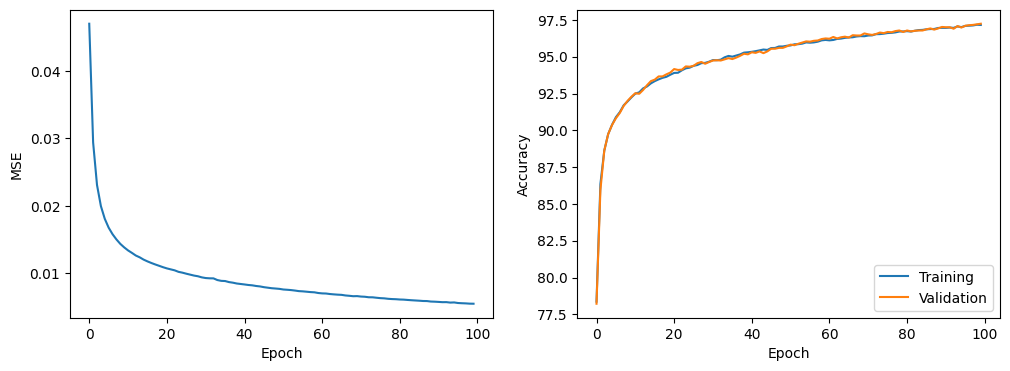

In [12]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model,
                                                     X_train, y_train,
                                                     X_val, y_val,
                                                     num_epochs = 100,
                                                     learning_rate = 0.1)

fig, axs = plt.subplots(1, 2, figsize =(12, 4))

ax = axs[0]
ax.plot(range(len(epoch_loss)), epoch_loss)
ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")

ax = axs[1]
ax.plot(range(len(epoch_train_acc)), epoch_train_acc, label = "Training")
ax.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label = "Validation")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.legend()

plt.show()

In [13]:
test_mse, test_acc = compute_mse_acc(model, X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 95.66%


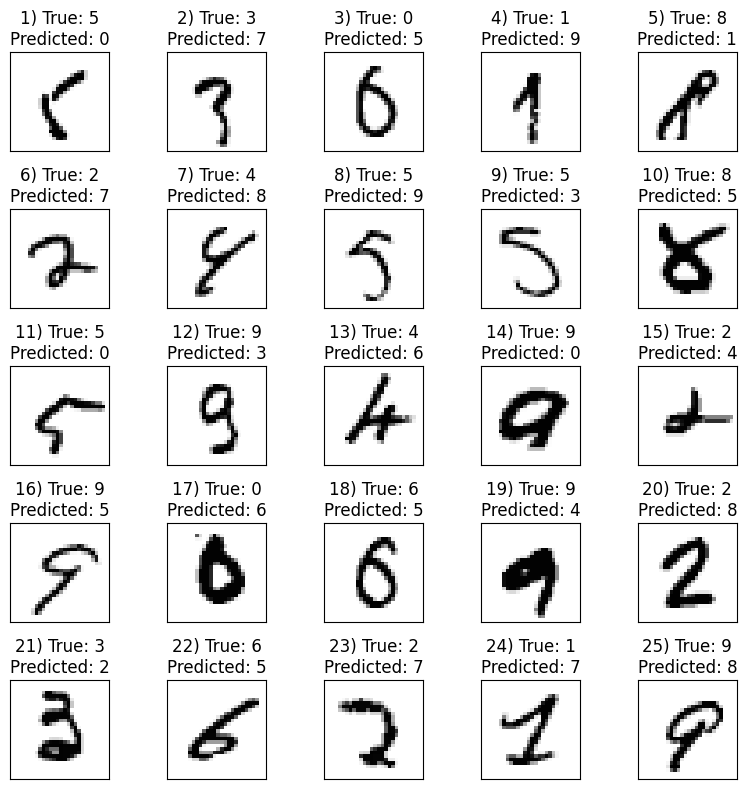

In [15]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probs = model.forward(X_test_subset)
test_pred = np.argmax(probs, axis = 1)

missclassified_imgs = X_test_subset[y_test_subset != test_pred][:25]
missclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize = (8,8))
ax = ax.flatten()

for i in range(25):
    img = missclassified_imgs[i].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {missclassified_labels[i]}')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()